# Algorithms for unconstrained nonlinear optimization. First- and second-order methods

In [698]:
import random
import math as m
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from math import sqrt
from sympy import *
from numpy import array
from numpy.linalg import norm, inv
from scipy import optimize

## Data Generation

In [728]:
eps = 1e-3
accuracy = round(m.log(1/eps, 10))
alpha = random.random()
beta = random.random()
n = 100
x = [k/n for k in range(n + 1)]
y = [alpha * x[k] + beta + random.normalvariate(0, 1) for k in range(n + 1)]

In [729]:
def linear_approx(a, b, x):
    return a * x + b

def linear_approx_derivative_a(a, b, x):
    """Производная по a"""
    return x

def linear_approx_derivative_b(a, b, x):
    """Производная по b"""
    return 1

def grad_linear_approx(a, b, x):
    """Градиент линейной аппроксимации"""
    return Vector(linear_approx_derivative_a(a, b, x), linear_approx_derivative_b(a, b, x))

In [730]:
def rational_approx(a, b, x):
    if 1 + x * b != 0:
        return a / (1 + b * x)
    else:
        return 1000000

def rational_approx_derivative_a(a, b, x):
    "Производная по a"
    if 1 + b * x != 0:
        return 1 / (1 + b * x)
    else:
        return 100000
    
def rational_approx_derivative_b(a, b, x):
    """Производная по b"""
    if 1 + b * x != 0:
        return -a * x / (1 + b * x) ** 2
    else:
        return 100000
    
def grad_rational_approx(a, b, x):
    """Градиент рациональной аппроксимации"""
    return Vector(rational_approx_derivative_a(a, b, x), rational_approx_derivative_b(a, b, x))

In [731]:
approx_grad = {
    rational_approx: grad_rational_approx,
    linear_approx: grad_linear_approx
}

def least_squares(func, a, b):
    d = 0
    for k in range(0, n + 1):
        d += (func(a, b, x[k]) - y[k]) ** 2 
    return d

def grad_least_squares(func, v):
    grad = Vector(0, 0)
    for k in range(0, n + 1):
        res = func(v.a, v.b, x[k]) - y[k]
        grad += 2 * res * approx_grad[func](v.a, v.b, x[k])
    return grad

In [733]:
def visualise_2d(predict_a_b, func):
    dpi = 80
    fig = plt.figure(dpi=dpi, figsize=(1024 / dpi, 512 / dpi))
    plt.scatter(x=x, y=y, c='r', label = "data generated") 
    
    for method in predict_a_b.keys():
        print(method, predict_a_b[method])
        y_k = [func(predict_a_b[method].a, predict_a_b[method].b, i) for i in x]
        plt.plot(x, y_k, label=method)
    
    y_k = [alpha * x[k] + beta for k in range(n + 1)]
    plt.plot(x, y_k, label="init line")
    
    plt.title(func.__name__)
    plt.grid(True)
    plt.legend()
    
    fig.set_figwidth(8)
    fig.set_figheight(8)
    plt.show()

In [734]:
class Vector(object):
    def __init__(self, a, b):
        self.a = a
        self.b = b
        self.value = 0
        
    def set_value(self, z):
        self.value = z

    def __repr__(self):
        return "({0}, {1})".format(self.a, self.b)

    def __add__(self, other):
        a = self.a + other.a
        b = self.b + other.b
        return Vector(a, b)

    def __sub__(self, other):
        a = self.a - other.a
        b = self.b - other.b
        return Vector(a, b)

    def __rmul__(self, other):
        a = self.a * other
        b = self.b * other
        return Vector(a, b)
    
    def __mul__(self, other):
        a = self.a * other
        b = self.b * other
        return Vector(a, b)

    def __truediv__(self, other):
        a = self.a / other
        b = self.b / other
        return Vector(a, b)
    
    def sum_vec(self):
        return self.a + self.b

    def c(self):
        return (self.a, self.b)
    
    def to_list(self):
        return [self.a, self.b]

## First-order methods

1. Gradient descent
2. (Nonlinear) Conjugate Gradient method

### Gradient descent

In [735]:
approx_grad = {
    rational_approx: grad_rational_approx,
    linear_approx: grad_linear_approx
}

def least_squares_bb(func, v):
    d = 0
    for k in range(0, n + 1):
        d += (func(v[0], v[1], x[k]) - y[k]) ** 2 
    return d

def grad_least_squares_bb(func, v):
    grad = Vector(0, 0)
    for k in range(0, n + 1):
        res = func(v[0], v[1], x[k]) - y[k]
        grad += 2 * res * approx_grad[func](v[0], v[1], x[k])
    return np.array([grad.a, grad.b])

def grad_descent(func, x, niter=100, verbose=False):
    msg = "Maximum number of iterations"
    g_old = grad_least_squares_bb(func, x)
    gamma = 0.9
    for cont in range(niter):
        if verbose:
            print(f"n: {cont}, x: {x}, func: {round(least_squares_bb(func, x),3)}")
        dx = - gamma * g_old
        x = x + dx
        g = grad_least_squares_bb(func, x)
        dg = g - g_old
        g_old = g
        # Barzilai-Borwein method
        gamma = abs(dx.dot(dg)) / dg.dot(dg)
        if norm(g) < eps:
            msg = f"Extremum found with desired accuracy in {cont + 1} iterations"
            break
    print(x, least_squares_bb(func, x), msg)
    vec = Vector(x[0], x[1])
    vec.set_value(least_squares_bb(func, x))
    return vec


vec_grad_descent_linear = grad_descent(linear_approx, [2.0, 2.0])
vec_grad_descent_rational = grad_descent(rational_approx, [2.0, 2.0])

[0.02924173 0.93251045] 116.09568423082601 Extremum found with desired accuracy in 5 iterations
[ 0.9319672  -0.03184379] 116.09532761283293 Extremum found with desired accuracy in 33 iterations


### Non-linear Conjugate Gradient Descent

In [737]:
def least_squares_conjugate_linear(v):
    d = 0
    v0, v1 = v
    for k in range(0, n + 1):
        d += (linear_approx(v0, v1, x[k]) - y[k]) ** 2 
    return d

def least_squares_conjugate_rational(v):
    d = 0
    v0, v1 = v
    for k in range(0, n + 1):
        d += (rational_approx(v0, v1, x[k]) - y[k]) ** 2 
    return d

def grad_least_squares_conjugate_rational(v):
    grad = Vector(0, 0)
    v0, v1 = v
    for k in range(0, n + 1):
        res = rational_approx(v0, v1, x[k]) - y[k]
        grad += 2 * res * approx_grad[rational_approx](v0, v1, x[k])
    return np.array([grad.a, grad.b])

def grad_least_squares_conjugate_linear(v):
    grad = Vector(0, 0)
    v0, v1 = v
    for k in range(0, n + 1):
        res = linear_approx(v0, v1, x[k]) - y[k]
        grad += 2 * res * approx_grad[linear_approx](v0, v1, x[k])
    return np.array([grad.a, grad.b])

x0 = np.asarray((0, 0))  # Initial guess.
res1 = optimize.fmin_cg(least_squares_conjugate_linear, x0, fprime=grad_least_squares_conjugate_linear)
print(res1)
vec_gd_conjugate_linear = Vector(res1[0], res1[1])
vec_gd_conjugate_linear.set_value(least_squares(linear_approx, res1[0], res1[1]))
res2 = optimize.fmin_cg(least_squares_conjugate_rational, x0, fprime=grad_least_squares_conjugate_rational)
vec_gd_conjugate_rational = Vector(res2[0], res2[1])
vec_gd_conjugate_rational.set_value(least_squares(rational_approx, res2[0], res2[1]))
print(res2)

Optimization terminated successfully.
         Current function value: 116.095684
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5
[0.02924211 0.93251115]
Optimization terminated successfully.
         Current function value: 116.095328
         Iterations: 11
         Function evaluations: 22
         Gradient evaluations: 22
[ 0.93196725 -0.03184372]


## Second-order methods

3. Newton’s method
4. Levenberg-Marquardt algorithm

### Newton’s method

In [762]:
def func(u):
    v0 = u[0]
    v1 = u[1]
    d = 0
    for k in range(0, n + 1):
        d += (linear_approx(v0, v1, x[k]) - y[k]) ** 2 
    return d

def funcdd(u, d):
    h = 1e-4
    x, y = u[0], u[1]
    xd, yd = d[0], d[1]

    result = func([x + xd * h, y + yd * h]) + func([x - xd * h, y - yd * h])
    for index, i in enumerate(d):
        if i == 1:
            d[index] = -1
            break
    else:
        d = [0, 0]
    xd, yd = d[0], d[1]
    result -= func([x + xd * h, y + yd * h]) + func([x - xd * h, y - yd * h])
    result /= 4 * h ** 2
    return result


def hesse_matrix(u):
    xk = u[0]
    yk = u[1]

    fxx = funcdd(u, [2, 0])
    fxy = funcdd(u, [1, 1])
    fyy = funcdd(u, [0, 2])
    return [[fxx, fxy],
            [fxy, fyy]]

print(hesse_matrix([2, 2]))
print(hessian_rational(Vector(2, 2)))

[[67.66999831597786, 100.99999485646549], [100.99999485646549, 201.99998971293098]]
[[ 67.784197   -24.03310282]
 [-24.03310282   9.88250174]]


In [750]:
def hessian_linear():
    h11 = 0
    h12 = 0
    h21 = 0
    h22 = 0
    for k in range(0, n + 1):
        h11 += 2 * x[k] ** 2
        h12 += 2 * x[k]
        h21 += 2 * x[k]
        h22 += 2
    return np.array([[h11, h12], [h21, h22]])   

def hessian_rational(vec):
    h11 = 0
    h12 = 0
    h21 = 0
    h22 = 0
    for k in range(0, n + 1):
        h11 += 2 / ((1 + vec.b * x[k]) ** 2)
        h12 += - 4 * vec.a * x[k] / ((1 + vec.b * x[k]) ** 3) + 2 * x[k] * y[k] / ((1 + vec.b * x[k]) ** 2)
        h21 += - 4 * vec.a * x[k] / ((1 + vec.b * x[k]) ** 3) + 2 * x[k] * y[k] / ((1 + vec.b * x[k]) ** 2)
        h22 += 6 * vec.a ** 2 * x[k] ** 2 / ((1 + vec.b * x[k]) ** 4) - 4 * vec.a * x[k] ** 2 * y[k] / ((1 + vec.b * x[k]) ** 3)
    return np.array([[h11, h12], [h21, h22]])  

In [792]:
def least_squares_bb(func, v):
    d = 0
    for k in range(0, n + 1):
        d += (func(v[0], v[1], x[k]) - y[k]) ** 2 
    return d

def grad_least_squares_bb(func, v):
    grad = Vector(0, 0)
    for k in range(0, n + 1):
        res = func(v[0], v[1], x[k]) - y[k]
        grad += 2 * res * approx_grad[func](v[0], v[1], x[k])
    return np.array([grad.a, grad.b])

def grad_descent_newton(func, x, niter=100, verbose=False):
    msg = "Maximum number of iterations"
    g_old = grad_least_squares_bb(func, x)
    gamma = 0.9
    for cont in range(niter):
        if verbose:
            print(f"n: {cont}, x: {x}, func: {round(least_squares_bb(func, x),3)}")
        if func == linear_approx:
            hes = inv(hessian_linear())
        else:
#             hes = inv(hesse_matrix(x))
            hes = inv(hessian_rational(Vector(x[0], x[1]))) 
        x = x - hes.dot(g_old)
        g = grad_least_squares_bb(func, x)
        g_old = g
        if norm(g) < eps:
            msg = f"Extremum found with desired accuracy in {cont + 1} iterations"
            break
    print(x, least_squares_bb(func, x), msg)
    vec = Vector(x[0], x[1])
    vec.set_value(least_squares_bb(func, x))
    return vec

vec_newton_linear = grad_descent_newton(linear_approx, [1.0, 1.0], verbose=True)
vec_newton_linear.set_value(least_squares(linear_approx, vec_newton_linear.a, vec_newton_linear.b))
vec_newton_rational = grad_descent_newton(rational_approx, [1, -0.5], verbose=True)
vec_newton_rational.set_value(least_squares(rational_approx, vec_newton_rational.a, vec_newton_rational.b))

n: 0, x: [1.0, 1.0], func: 155.058
[0.02924211 0.93251115] 116.09568423074415 Extremum found with desired accuracy in 1 iterations
n: 0, x: [1, -0.5], func: 143.15
n: 1, x: [ 0.47166821 -0.62990943], func: 124.668
n: 2, x: [ 0.70989402 -0.39078687], func: 117.764
n: 3, x: [ 0.8609629  -0.18105324], func: 116.305
n: 4, x: [ 0.91849086 -0.06633624], func: 116.106
n: 5, x: [ 0.93111349 -0.03422498], func: 116.095
[ 0.93196282 -0.03185636] 116.0953276143749 Extremum found with desired accuracy in 6 iterations


### Levenberg-Marquardt algorithm

## Visualise

gradient_descent (0.029241730857684, 0.932510447838534)
gd_conjugate_non-linear (0.029242108490785346, 0.9325111524741329)
newton (0.02924210849078346, 0.9325111524741336)


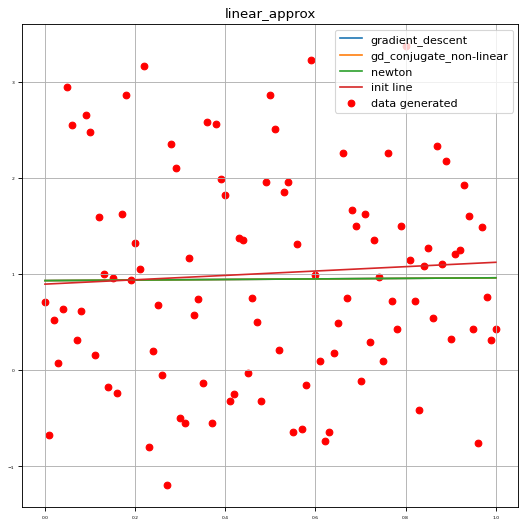

gradient_descent (0.9319672040296265, -0.03184379429194732)
gd_conjugate_non-linear (0.9319672451079317, -0.03184372072994269)
newton (0.9319628186954958, -0.03185636366508001)


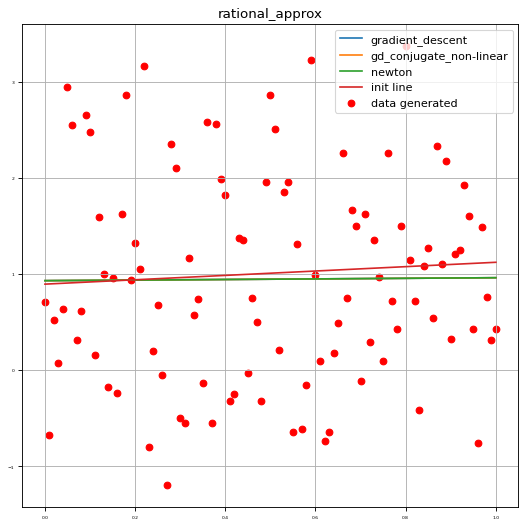

In [793]:
linear_predict_a_b = {
    "gradient_descent": vec_grad_descent_linear,
    "gd_conjugate_non-linear": vec_gd_conjugate_linear,
    "newton": vec_newton_linear
}
rational_predict_a_b = {
    "gradient_descent": vec_grad_descent_rational,
    "gd_conjugate_non-linear": vec_gd_conjugate_rational,
    "newton": vec_newton_rational
}
visualise_2d(linear_predict_a_b, linear_approx)
visualise_2d(rational_predict_a_b, rational_approx)